In [1]:
from itertools import chain
from pathlib import Path
import torch
from torch import nn
from torch.utils.data.dataloader import DataLoader

from tokenizers import ByteLevelBPETokenizer

import numpy as np

from languages_list import Languages

from gh_dataset import GHDataset
from matplotlib import pyplot as plt

import tqdm
import pickle
import json

from sklearn.model_selection import train_test_split

tokenizer = ByteLevelBPETokenizer(
    "./artifacts/tokenizer-vocab.json", 
    "./artifacts/tokenizer-merges.txt"
)

In [2]:
dataset = GHDataset(tokenize=True, subsample_lines=True)

In [3]:
idxs = np.arange(len(dataset))
train_gru, idxs = train_test_split(idxs, test_size=0.66, random_state=42)
train_svc, test = train_test_split(idxs, test_size=0.5, random_state=42)


splits = {
    "train_gru": [dataset.files[i].as_posix() for i in train_gru],
    "train_svc": [dataset.files[i].as_posix() for i in train_svc],
    "test": [dataset.files[i].as_posix() for i in test],
}

with open("../telegram-ml-contest-data/splits.json", "w") as file:
    json.dump(splits, file)

In [4]:
len(train_gru), len(train_svc), len(test)

(349868, 339578, 339579)

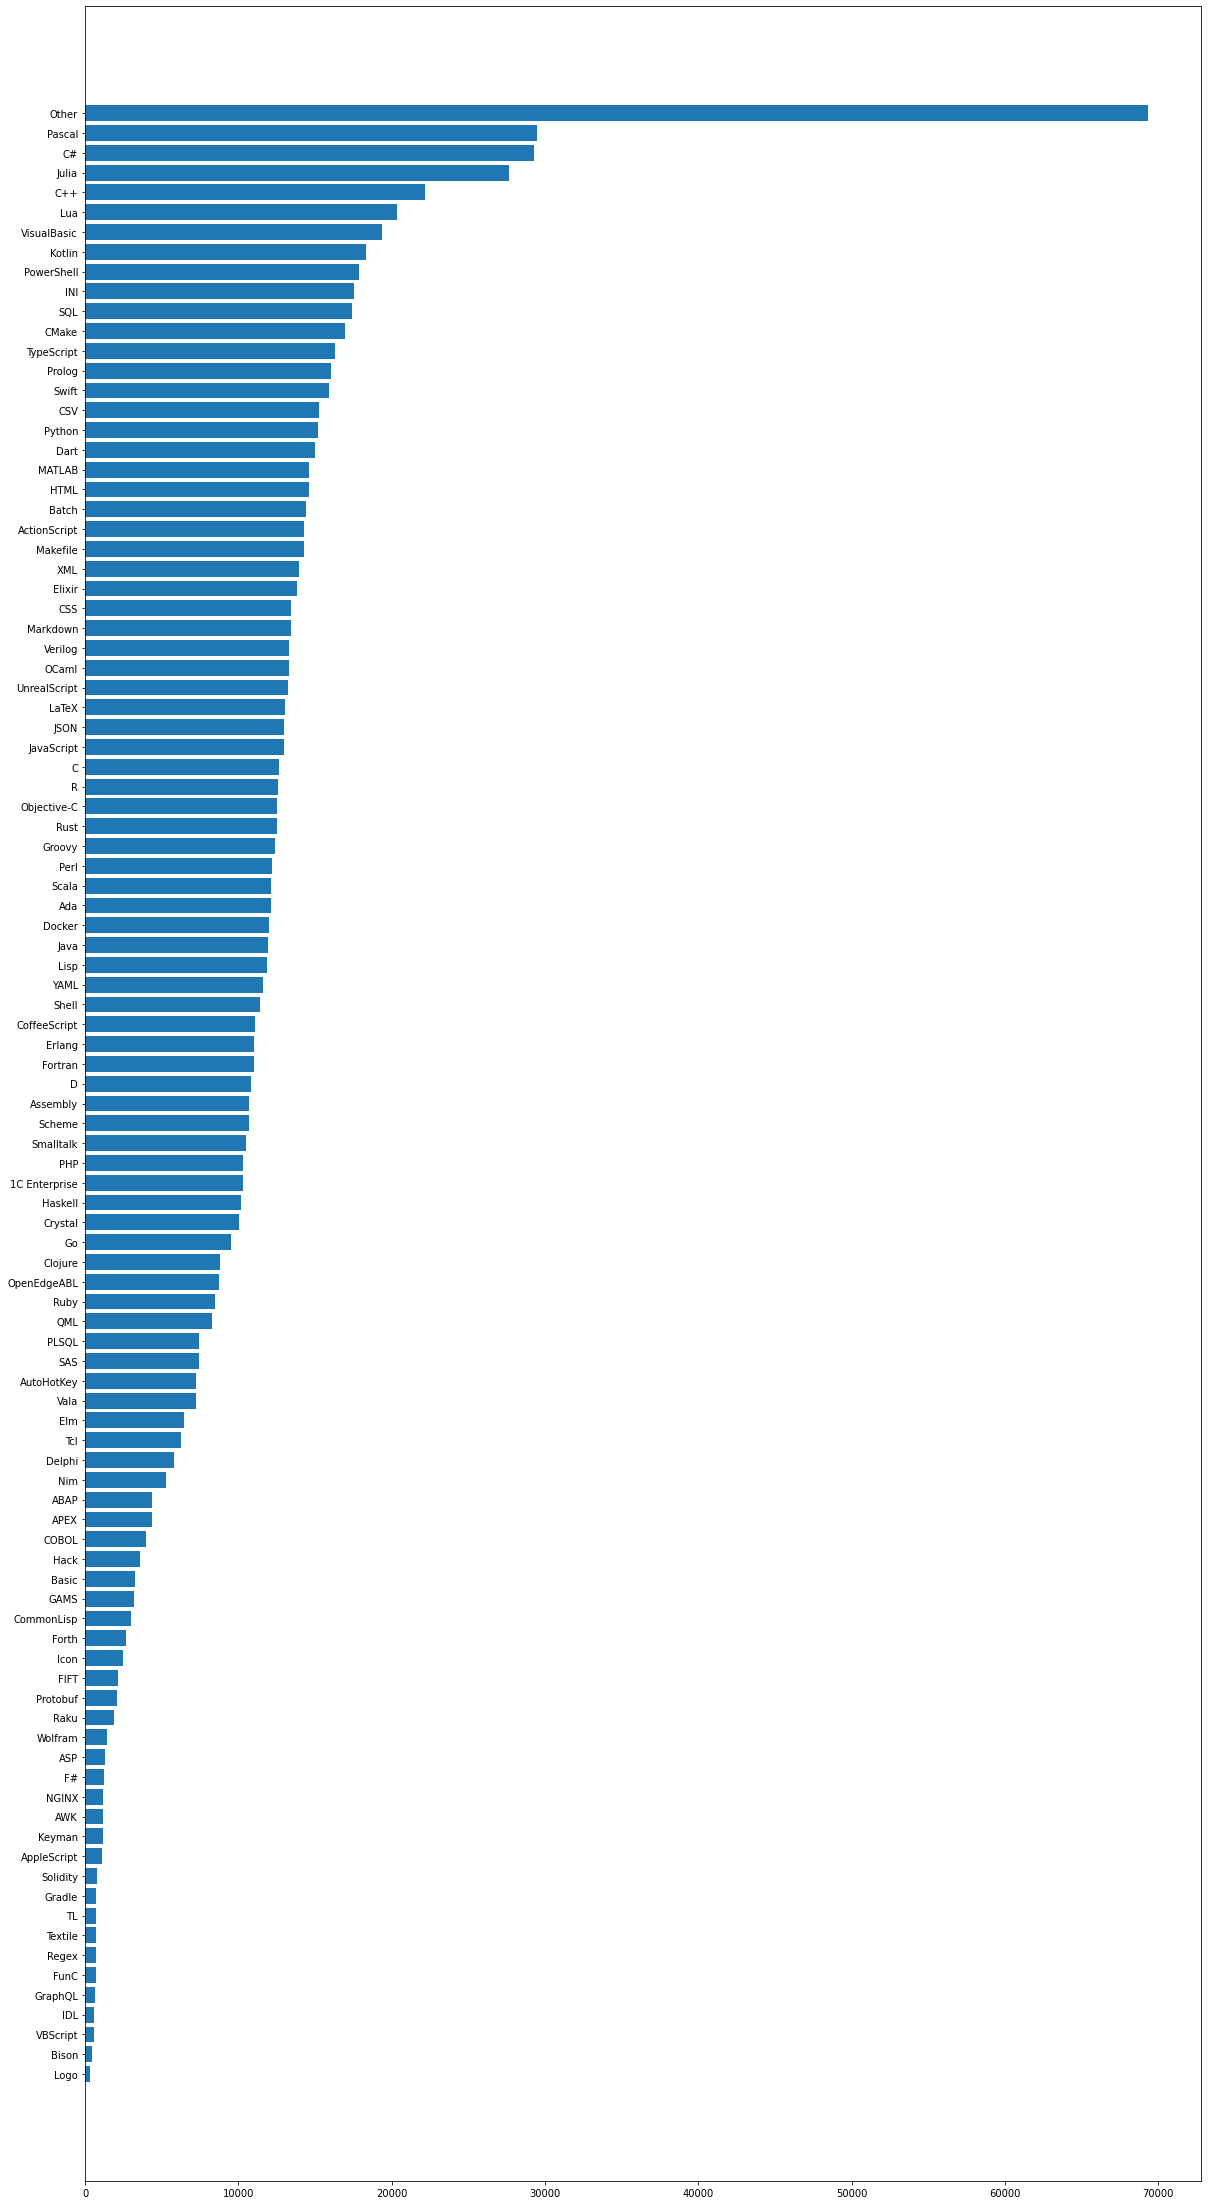

In [5]:
from collections import Counter
counts = Counter(dataset.labels)

labels = [Languages.to_string(i+1) for i in range(100)]
occurences = np.array([counts[Languages.from_string(label)] for label in labels])

order = np.argsort(occurences)

plt.figure(figsize=[20, 40])
# plt.barh(np.arange(100), (occurences[order] / occurences.max())**(-0.1), alpha=1)
plt.barh(np.arange(100), occurences[order], alpha=1)

plt.yticks(np.arange(100), np.array(labels)[order])
plt.show()

In [2]:
train_dataset = GHDataset(split="train_gru", tokenize=True, subsample_lines=True)
val_dataset = GHDataset(split="test", tokenize=True, subsample_lines=True)

In [3]:
class Batch(dict):
    def __init__(self, dict):
        self.update(dict)

    def to(self, device):
        items = []
        for k, v in self.items():
            if isinstance(v, torch.Tensor):
                items.append((k, v.to(device)))

        for k, v in items:
            self[k] = v

        return self

pad_token = tokenizer.token_to_id("<pad>")
max_seq_len = 8192

def collate_fn(batch):
    ids, labels = zip(*batch)
    
    max_len = max(len(i) for i in ids)
    max_len = min(max_len, max_seq_len)
    max_len = (max_len + 15) // 16 * 16

    ids = torch.tensor([
        i[:max_len] + [pad_token for j in range(max_len - len(i))]
        for i in ids
    ])
    mask = ids != pad_token
    last_element = mask.sum(dim=1) - 1
    labels = torch.tensor([label.value - 1 for label in labels])

    return Batch({
        "ids": ids,
        "mask": mask,
        "last_element": last_element,
        "labels": labels, 
    })

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=2**15, embedding_dim=96)
        self.gru = nn.GRU(input_size=96, hidden_size=96, batch_first=True)
        self.classifier = nn.Linear(96, 100)

    def forward(self, ids, last_elements, return_last_feature=False):
        """ ids: [batch_size, seq_len]
        """
        batch_size = ids.shape[0]

        # [batch_size, seq_len, emb_dim]
        emb = self.embedding(ids)

        # [batch_size, seq_len, emb_dim]
        features, _ = self.gru(emb)

        last_feature = features[range(batch_size), last_elements]

        # [batch_size, hid_dim] -> [batch_size, 100]
        logits = self.classifier(last_feature)

        if not return_last_feature:
            return logits
        
        return logits, last_feature
     

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [4]:
from tensorboardX import SummaryWriter 

# continue_from_val = True
# if not continue_from_val:
model = Network()
model.load_state_dict(torch.load("gru_weights/model_99.pth"))
model.cuda()

writer = SummaryWriter()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
cross_entropy = nn.CrossEntropyLoss()

step = 0


In [5]:
for epoch in tqdm.trange(50, 100):
    model.train()
    cross_entropy.reduction = "mean"
    for batch in tqdm.tqdm(train_dataloader):
        batch.to("cuda")

        logits = model(batch["ids"], batch["last_element"])
        loss = cross_entropy(logits, batch["labels"])

        loss.backward()
        optim.step()
        optim.zero_grad()

        writer.add_scalar("train_loss", loss.item(), step)
        step += 1

    avg_loss = 0
    avg_acc = 0
    n_batches = 0

    model.eval()
    cross_entropy.reduction = "sum"
    for batch, _ in zip(val_dataloader, tqdm.trange(1000)):
        batch.to("cuda")
        
        with torch.no_grad():
            logits = model(batch["ids"], batch["last_element"])

        loss = cross_entropy(logits, batch["labels"])
        avg_loss += loss.item()
        avg_acc += (logits.argmax(dim=-1) == batch["labels"]).float().sum().item()
        n_batches += batch["ids"].shape[0]

    avg_loss /= n_batches
    avg_acc /= n_batches

    writer.add_scalar("val_loss", loss, step)
    writer.add_scalar("val_acc", avg_acc, step)

    # continue_from_val = False

    torch.save(model.state_dict(), f"gru_weights2/model_{epoch}.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

: 

In [12]:
model = Network()
model.load_state_dict(torch.load("gru_weights/model_99.pth"))
model.cuda().eval()

labels = []
predictions = []
last_features = []

for batch in tqdm.tqdm(val_dataloader):
    batch.to("cuda")

    # print(batch["last_element"])
    # break
    
    with torch.no_grad():
        logits, last_feature = model(batch["ids"], batch["last_element"], return_last_feature=True)

    labels.append(batch["labels"])
    predictions.append(logits.argmax(dim=-1))
    last_features.append(last_feature)

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

tensor([8191,   93,  984,  118,   50,   36, 1017,   35,   36, 8191,   16,  312,
        3665,  112,  443,   32], device='cuda:0')


In [ ]:
optim = torch

In [14]:
batch.to("cuda")

In [40]:

    
model = Network()

In [41]:
model(batch["ids"], batch["last_element"]).shape

torch.Size([2, 100])